In [1]:
import torch
import torchvision

import os
import numpy as np
import matplotlib.pyplot as plt

from coshrem.shearletsystem import EdgeSystem
from coshrem.util.image import overlay, mask, thin_mask, curvature_rgb
from coshrem.util.curvature import curvature
import coshrem.util
from PIL import Image
from shnetutil.cplx import visual

fftlib = np.fft

In [17]:
import os, time
import numpy as np
from PIL import Image
from coshrem.shearlet import construct_shearlet
from numpy.random import randint
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from skimage.transform import resize

#import numba

from coshrem.util.cone import cone_orientation
from coshrem.shearlet import yapuls, padarray, shear, construct_shearlet
from matplotlib.colors import hsv_to_rgb

import torch

from shnetutil import cplx, shxform
from shnetutil.shxform import CoShREMConfig
import cplxmodule
from shnetutil.utils import torchutils
from shnetutil.cplx import visual

# Default parameters for our Shearlet system
# https://www.math.colostate.edu/~king/software/CoShREM_Parameter_Guide.pdf
#

ksh_spec = CoShREMConfig(
			rows = 32,
			cols = 32,
			scales_per_octave = 2,
			shear_level = 3,
			octaves = 1,
			alpha = .5,	#   Anisotropy level
						#	alpha: coefficient determining level of anisotropy. 
						#	1 -> wavelets, 
						#	0.5 -> shearlets, 
						#	0 -> ridgelets... etc.

			wavelet_eff_support = 7,
			gaussian_eff_support = 14,
)

def get_sh_spec(rows:int, cols:int, alpha:float=0.5):
	""" Configure a sh_spec for our Shearlet system """
	sh_spec = ksh_spec.copy()
	sh_spec['rows'] = rows
	sh_spec['cols'] = cols
	sh_spec['alpha'] = alpha
	return sh_spec

def get_CoShXform(device:str, rows:int, cols:int, alpha:float=0.5):
	""" Start a CoShXform """
	sh_spec = get_sh_spec(rows, cols, alpha)
	coshxform = CoShXform(sh_spec)
	coshxform.start(device)
	return coshxform	

def power_of_two(target):
	""" round to next power-of-2 """
	if target > 1:
		for i in range(1, int(target)):
			if (2 ** i >= target):
				return 2 ** i
	else:
		return 1

class CoShXform(shxform.ShXform):
	def __init__(self,
		sh_spec = ksh_spec, 
		tocplx = False,
		topolar = False,
		phase_first = False
	):
		""" Generating the shearlet system with pyCoShRem """
		super().__init__(sh_spec=sh_spec)	#default complex Shearlet spec - usually provided by client
		nextp2 = power_of_two(self.dim[0])
		assert(nextp2 == self.dim[0])
		self.ourdim = (nextp2, nextp2)
		self.tocplx = tocplx
		self.topolar = topolar
		self.phase_first = phase_first
		#print(f"CoShXform: {sh_spec}")

	def __repr__(self):	
		return f"CoShXform({self.sh_spec})"	

	def __str__(self):
		return f"CoShXform({self.sh_spec})"	

	def start(self, device):
		super().start(device)

		#t = time.time()
		self._shearletSystem = getcomplexshearlets2D(**dict(self.sh_spec))
		#self.shearlets, self.shearletIdxs = self.shearletSystem
		#print(f"Elapsed time: getcomplexshearlets2D() {time.time()-t:3f}ms")

		#for pytorch deal with the imaginary and real part we separate them into two arrays
		shearlets_complex = to_torch_complex(self.shearlets)
		self.shearlets_complex = shearlets_complex
		self.torch_shearlets = torch.tensor(shearlets_complex).unsqueeze(0).to(device).float()
	
def to_torch_complex(shearlets):
	"""for pytorch to deal with the imaginary and real part we separate them into two arrays """
	#print(f"to_torch_complex {shearlets.shape}")
	shearlets_complex = np.concatenate((
		shearlets.real[:,:,:,np.newaxis], 
		shearlets.imag[:,:,:,np.newaxis]), 
		3
	)
	return shearlets_complex

# ## Relevant CoShReM function

# Single shearlet computation
def _single_shearlet(
	rows, cols, 
	wavelet_eff_supp,
	gaussian_eff_supp, scales_per_octave,
	shear_level, alpha, 
	sample_wavelet_off_origin,
	scale, ori, _coneh, _ks, hilbert_matrix
):
	shearlet_f = construct_shearlet(rows, cols, wavelet_eff_supp,
								  gaussian_eff_supp, scales_per_octave,
								  shear_level, alpha,
								  sample_wavelet_off_origin, scale, ori, _coneh, _ks)

	if ori in _coneh:
		shearlet_f = shearlet_f + (hilbert_matrix[:, :, 0] * shearlet_f)
		# shearlet_f = np.fliplr(np.flipud(_hilbert_f(shearlet_f * -1)))
		# if not self.sampleWaveletOffOrigin:
		#     shearlet_f = np.roll(shearlet_f, -1, axis=0)
	else:
		if ori > np.max(_coneh):
			shearlet_f = -1 * (shearlet_f + hilbert_matrix[:, :, 1] * shearlet_f)
			# shearlet_f = _hilbert_f(shearlet_f.T * -1).T
			# shearlet_f = np.roll(shearlet_f, 1, axis=1)
		else:
			shearlet_f = shearlet_f + hilbert_matrix[:, :, 1] * shearlet_f
			# shearlet_f = _hilbert_f(shearlet_f.T).T
	return shearlet_f

def getcomplexshearlets2D(
	rows, 
	cols, 
	scales_per_octave, 
	shear_level, 
	octaves, alpha,
	wavelet_eff_support = 7,
	gaussian_eff_support = None,
):

	# Parameters precomputing
	gaussian_eff_support = gaussian_eff_support if gaussian_eff_support else wavelet_eff_support * 2 
	wavelet_eff_supp = np.min((rows, cols)) / wavelet_eff_support
	gaussian_eff_supp = np.min((rows, cols)) / gaussian_eff_support
	sampleWaveletOffOrigin= True

	hilbert_matrix = np.ones((rows, cols, 2))
	hilbert_matrix[:(rows//2), :, 0] = -1
	hilbert_matrix[:, (cols//2):, 1] = -1
	n_oris = 2 ** shear_level + 2
	scales = np.arange(1, (scales_per_octave * octaves) + 1)
	n_shearlets = len(scales) * n_oris

	normalize=True
	_, _coneh, _ks =  cone_orientation(shear_level)
	shearlets = np.zeros((rows, cols,n_shearlets), dtype=np.complex_)
	shearletidx = []
	# Computing shearlets
	for j, scale in enumerate(scales):
		for ori in range(n_oris):
			shearlet = _single_shearlet(rows, cols, wavelet_eff_supp,
						   gaussian_eff_supp, scales_per_octave,
						   shear_level, alpha, sampleWaveletOffOrigin,
						   scale, ori+1, _coneh, _ks, hilbert_matrix)

			if ori in _coneh:
				shearletidx.append([1,int(scale), _ks[ori]])
			else:
				shearletidx.append([2,int(scale), _ks[ori]])
			shearlets[:, :, n_oris * j + ori] = shearlet
	# Computing RMS (Root mean square)
	RMS = np.linalg.norm(shearlets[0], axis=(0, 1))/np.sqrt(rows*cols)
	dualFrameWeights = np.sum(np.power(np.abs(shearlets), 2), axis=2)
	return shearlets, shearletidx, RMS, dualFrameWeights



In [39]:
def is_peak(coeffs):
    coeffs = np.array(coeffs)
    up = np.roll(coeffs, 1, -2)
    down = np.roll(coeffs, -1, -2)
    right = np.roll(coeffs, 1, -3) < coeffs
    left = np.roll(coeffs, -1, -3) < coeffs

    up_right = np.roll(coeffs, 1, -3) < coeffs
    up_left = np.roll(coeffs, -1, -3) < coeffs
    down_right = np.roll(down, 1, -3) < coeffs
    down_left = np.roll(down, -1, -3) < coeffs

    up = up < coeffs
    down = down < coeffs

    mask = up * down * right * left * up_right * up_left * down_right * down_left
    return mask

def suppress_peaks(coeffs):
    peaks = is_peak(coeffs)
    coeffs[peaks] = 0
    return coeffs

def suppress_non_peak(coeffs):
    peaks = is_peak(coeffs)
    coeffs[~peaks] = 0
    return coeffs
    
def suppress_small(coeffs, percent=10):
    importance = np.abs(coeffs.real)

    qLower = np.percentile(importance, percent) # 10% sparsity
    mask = importance < qLower

    coeffs[mask] = 0

    return coeffs 


def suppress_square(coeffs, i=1):
    x, y = coeffs.shape[0], coeffs.shape[1]

    coeffs[-i:] = 0
    coeffs[:i] = 0
    coeffs[:, :i] = 0
    coeffs[:, -i:] = 0

    return coeffs 

def sheardec2D(X, shearlets):
    #skipping useGPU stuff...
    coeffs = np.zeros(shearlets.shape, dtype=complex)

    # get data in frequency domain
    Xfreq = fftlib.fftshift(fftlib.fft2(fftlib.ifftshift(X)))
    # print('frequency domain')
    # visual.complexImageShow(Xfreq / Xfreq.max())
    # plt.show()

    # compute shearlet coefficients at each scale
    # note that pointwise multiplication in the fourier domain equals
    # convolution in the time-domain
    for j in range(shearlets.shape[-1]):
        coeffs[:,:,j] = fftlib.fftshift(fftlib.ifft2(fftlib.ifftshift(Xfreq * np.conj(shearlets[:,:,j]))))

    return coeffs


def shearrec2D(coeffs, shearlets, dualFrameWeights):
    # skipping useGPU stuff...
    X = np.zeros((coeffs.shape[0], coeffs.shape[1]), dtype=complex)
    Y = np.zeros((coeffs.shape[0], coeffs.shape[1]), dtype=complex)

    for j in range(shearlets.shape[-1]):
        X = X + fftlib.fftshift(fftlib.fft2(fftlib.ifftshift(coeffs[:,:,j]))) * shearlets[:,:,j]
        Y = Y + fftlib.fftshift(fftlib.fft2(fftlib.ifftshift(coeffs[:,:,j])))
    
    X = suppress_square(X, 96)
    Y = suppress_square(Y, 96)

    print((X == 0).sum() / X.flatten().shape[0], 'sparsity')
    print('shearlet conv domain')
    visual.complexImageShow(Y / Y.max())
    plt.show()

    InversedualFrameWeights = 1 / dualFrameWeights
    InversedualFrameWeights[InversedualFrameWeights==np.inf] = 0.0

    X = fftlib.fftshift(fftlib.ifft2(fftlib.ifftshift((X*InversedualFrameWeights))))

    return np.real(X)

<class 'numpy.ndarray'> 0 254


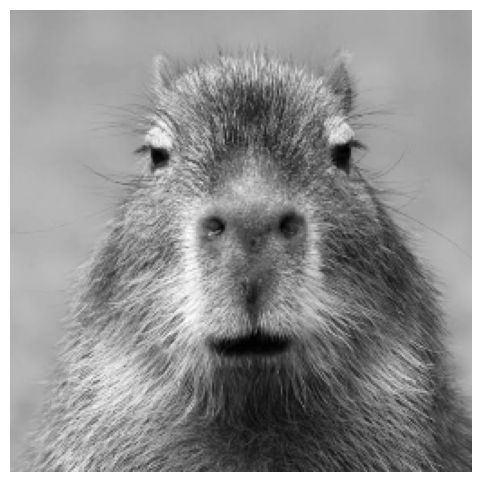

sh_spec: rows=256 cols=256 scales_per_octave=1 shear_level=3 octaves=2 alpha=0.5 wavelet_eff_support=128 gaussian_eff_support=64
torchutils.onceInit device = cpu
initSeeds(1)
0.09726300631430879
0.953125 sparsity
shearlet conv domain


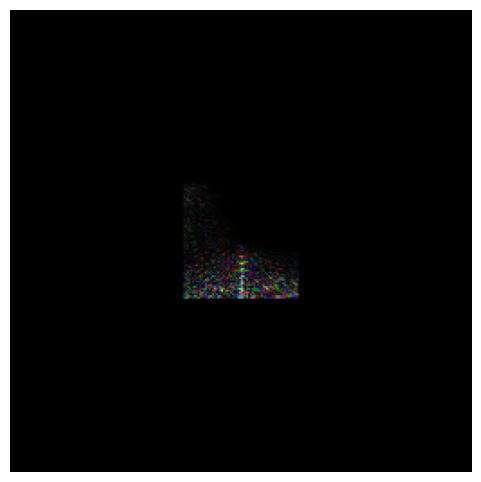

C:\Users\jaycr\AppData\Local\Temp\ipykernel_25356\2533114690.py:86: RuntimeWarning: divide by zero encountered in divide
  InversedualFrameWeights = 1 / dualFrameWeights


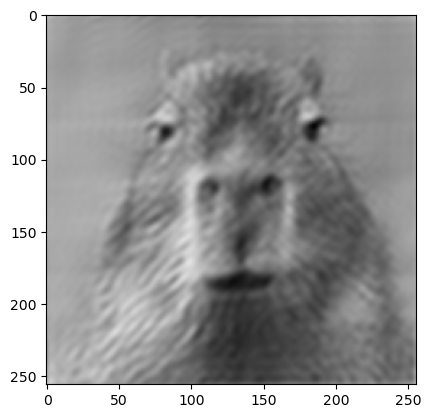

In [97]:
size = 256
img = np.array(Image.open("capybara.png").convert('L'))
print(type(img), img.min(), img.max())
image = resize(img, (size,size))

plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(image, cmap = "gray")
plt.show()

# Relevant parameters for our Shearlet system
rows, cols = image.shape
sh_spec = CoShREMConfig(rows = rows,
                        cols = cols,
                        scales_per_octave = 1,
                        shear_level = 3,
                        octaves = 2,
                        alpha = 0.5,
                        wavelet_eff_support = 128,
                        gaussian_eff_support = 64)

print(f"sh_spec: {sh_spec}")

# Generating the shearlet system with pyCoShRem
device = torchutils.onceInit(kCUDA=True)
coshxform = CoShXform(sh_spec)
coshxform.start(device)

shearlets, shearletIdxs, RMS, dualFrameWeights = coshxform.shearletSystem

print(RMS)

coeffs = sheardec2D(image, shearlets)
recon = shearrec2D(coeffs, shearlets, dualFrameWeights)

#recon = recon.real - recon.real.min()
#recon = recon / recon.max()

# visual.complexImageShow(recon)
plt.imshow(recon.real, cmap='gray', vmin=0, vmax=1)
plt.show()

In [98]:
# GOAL: get the input that is passed to coshnet (coefficients or shearlet space?) with the intended sparsity level.

def sparse_shearenc2D(X, shearlets):
    #skipping useGPU stuff...
    coeffs = np.zeros(shearlets.shape, dtype=complex)

    # get data in frequency domain
    Xfreq = fftlib.fftshift(fftlib.fft2(fftlib.ifftshift(X)))
    # print('frequency domain')
    # visual.complexImageShow(Xfreq / Xfreq.max())
    # plt.show()

    # compute shearlet coefficients at each scale
    # note that pointwise multiplication in the fourier domain equals
    # convolution in the time-domain
    X = np.zeros((coeffs.shape[0], coeffs.shape[1]), dtype=complex)
    Y = np.zeros((coeffs.shape[0], coeffs.shape[1]), dtype=complex)
    
    # TODO: vectorize

    X = Xfreq[..., np.newaxis] * np.conj(shearlets) * shearlets
    Y = Xfreq[..., np.newaxis] * np.conj(shearlets)

    X = suppress_square(X, 96)
    Y = suppress_square(Y, 96)

    # TODO: use torch so we can vectorize even this process
    for j in range(shearlets.shape[-1]):
        coeffs[:,:,j] = fftlib.fftshift(fftlib.ifft2(fftlib.ifftshift(Y[:,:,j])))

    print((X == 0).sum() / X.flatten().shape[0], 'sparsity')
    print('shearlet conv domain')
    visual.complexImageShow(Y.sum(-1) / Y.sum(-1).max())
    plt.show()

    print('coeffs domain')
    visual.complexImageShow(coeffs.sum(-1) / coeffs.sum(-1).max())
    plt.show()

    return coeffs


def sparse_sheardec2D(coeffs, shearlets, dualFrameWeights):
    # skipping useGPU stuff...
    X = np.zeros((coeffs.shape[0], coeffs.shape[1]), dtype=complex)
    Y = np.zeros((coeffs.shape[0], coeffs.shape[1]), dtype=complex)

    for j in range(shearlets.shape[-1]):
        X = X + fftlib.fftshift(fftlib.fft2(fftlib.ifftshift(coeffs[:,:,j]))) * shearlets[:,:,j]
        Y = Y + fftlib.fftshift(fftlib.fft2(fftlib.ifftshift(coeffs[:,:,j])))
    
    X = suppress_square(X, 112)
    Y = suppress_square(Y, 112)

    print((X == 0).sum() / X.flatten().shape[0], 'sparsity')
    print('shearlet conv domain')
    visual.complexImageShow(Y / Y.max())
    plt.show()
    

    InversedualFrameWeights = 1 / dualFrameWeights
    InversedualFrameWeights[InversedualFrameWeights==np.inf] = 0.0

    X = fftlib.fftshift(fftlib.ifft2(fftlib.ifftshift((X * InversedualFrameWeights))))

    return np.real(X)

0.96875 sparsity
shearlet conv domain


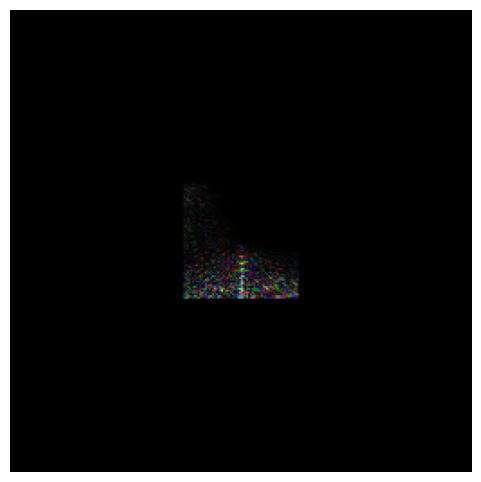

coeffs domain


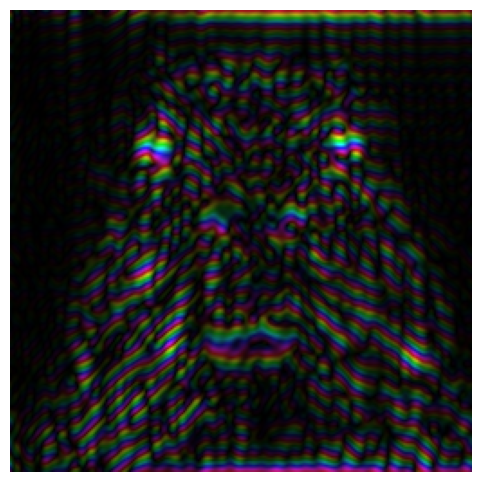

0.98828125 sparsity
shearlet conv domain


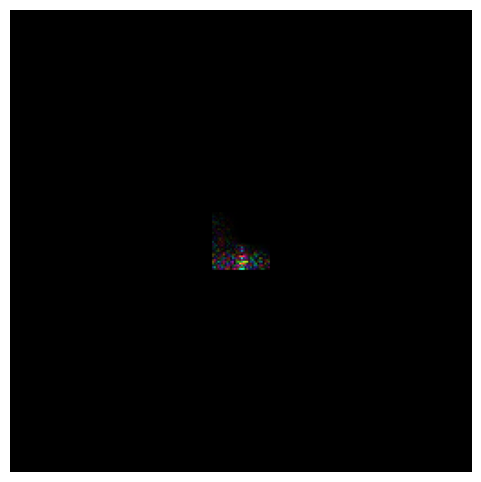

C:\Users\jaycr\AppData\Local\Temp\ipykernel_25356\2219500691.py:61: RuntimeWarning: divide by zero encountered in divide
  InversedualFrameWeights = 1 / dualFrameWeights


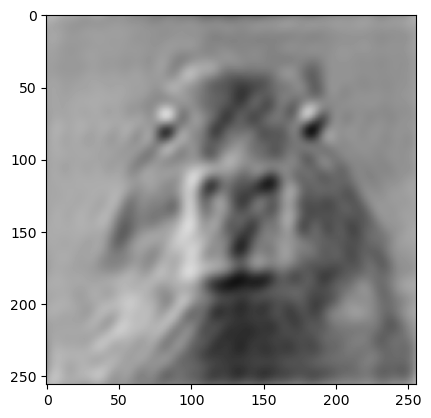

In [99]:
# GOAL: determine the best input format to tokenize to use few constant-sized tokens for any resolution.
coeffs = sparse_shearenc2D(image, shearlets)
recon = sparse_sheardec2D(coeffs, shearlets, dualFrameWeights)

plt.imshow(recon.real, cmap='gray', vmin=0, vmax=1)
plt.show()
# the input is not structurally (or at all?) sparse in the coefficient domain.
# the structure of our sparsity is only present in the frequency domain, so we must use that.


In [100]:
# GOAL: tokenize the input

# there are a couple of ways we can approach tokenizing the frequency domain input:

# 1. take some patch size and just take that much from the center of the band and use each band as a token.
# for patch sizes like 32x32 this requires large weight matrices automatically.
# this approach virtually limits the detail that can be processed by any network as the weight/space complexity is quadratic in the "detail"
# this approach might have many tokens
# this approach requires only a single dimension of positional embedding

# 2. patch the frequency domain into tokens
# this approach limits the resolutions that can be sparsified
# this approach requires two domains of positional embedding


def shearlet_tokens(X, shearlets, patch_size=32):
    #skipping useGPU stuff...
    coeffs = np.zeros(shearlets.shape, dtype=complex)

    # get data in frequency domain
    Xfreq = fftlib.fftshift(fftlib.fft2(fftlib.ifftshift(X)))
    # print('frequency domain')
    # visual.complexImageShow(Xfreq / Xfreq.max())
    # plt.show()

    # compute shearlet coefficients at each scale
    # note that pointwise multiplication in the fourier domain equals
    # convolution in the time-domain
    X = np.zeros((coeffs.shape[0], coeffs.shape[1]), dtype=complex)
    Y = np.zeros((coeffs.shape[0], coeffs.shape[1]), dtype=complex)
    
    # TODO: vectorize

    X = Xfreq[..., np.newaxis] * np.conj(shearlets) * shearlets
    Y = Xfreq[..., np.newaxis] * np.conj(shearlets)

    X = suppress_square(X, 96)
    Y = suppress_square(Y, 96)

    # TODO: use torch so we can vectorize even this process
    for j in range(shearlets.shape[-1]):
        coeffs[:,:,j] = fftlib.fftshift(fftlib.ifft2(fftlib.ifftshift(Y[:,:,j])))

    print((X == 0).sum() / X.flatten().shape[0], 'sparsity')
    print('shearlet conv domain')
    visual.complexImageShow(Y.sum(-1) / Y.sum(-1).max())
    plt.show()

    print('coeffs domain')
    visual.complexImageShow(coeffs.sum(-1) / coeffs.sum(-1).max())
    plt.show()

    return coeffs